***

### **TRABAJO FINAL GEOMETRÍA PROYECTIVA - LUCÍA RODRÍGUEZ**

***

Se importan las librerías donde están localizadas las funciones para realizar el trabajo:

* numpy: para tratar con los datos adquiridos
* cv2: librería para trabajar con imágenes, hay que tener en cuenta que devuelve el espacio de color como BGR
* matplotlib: librería para trabajar con imágenes, su espacio de color es RGB

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## *Parte 1: Homografía y Proyección Planar*
*Utilizando únicamente la imagen datos\imagenes\img_001.jpg:*

***Apartado (1):***

*Calcular la homografía H entre el plano que contiene al tablero de ajedrez y el plano de la pantalla,*
*situando el origen de coordenadas del plano que contiene al tablero de ajedrez en la esquina inferior interna*
*izquierda del tablero y teniendo en cuenta que el lado de cada casilla del tablero mide 4 cm.*

Tras leer la imagen y encontrar todas las intersecciones del tablero, se localizan los corners que forman el rectángulo más alejado para así evitar distorsiones posteriormente, aunque serviría 4 puntos cualquiera siempre que estén bien relacionados con los puntos de la realidad del tablero. puntos_pH1 hace referencia (todavía sin redondear decimales) a los puntos dibujados en amarillo de la imagen 2D.

Para representar he utilizado plot para que se refleje en el jupyter junto con el origen de coordenadas

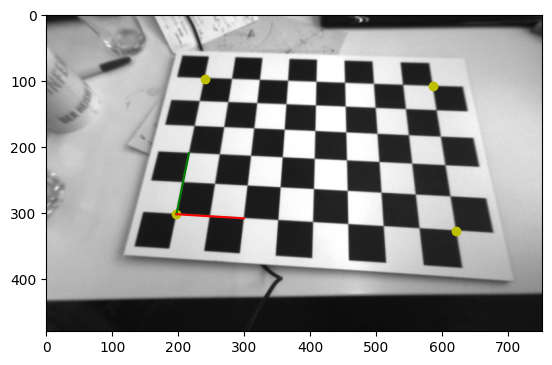

In [2]:
img1 = cv2.imread("datos\imagenes\img_001.jpg")
[frames,found_corners] = cv2.findChessboardCorners(img1,[6,9])

corners = np.squeeze(found_corners)

p1 = corners[0,:]
p2 = corners[5,:]
p3 = corners[53,:]
p4 = corners[48,:]

puntos_pH1 = np.array([p1,p2,p3,p4]) 

plt.imshow(img1)

plt.plot(p1[0],p1[1],'yo')
plt.plot(p2[0],p2[1],'yo')
plt.plot(p3[0],p3[1],'yo')
plt.plot(p4[0],p4[1],'yo')

plt.plot([p1[0],corners[2,0]],[p1[1],corners[2,1]],"g")

plt.plot([p1[0],corners[12,0]],[p1[1],corners[12,1]],"r")

A continuación, se eligen los puntos de la realidad del tablero. Siguiendo la notación de la fórmula p=H*P, durante todo el proyecto para los puntos proyectados en la imagen se utiliza la letra p minúscula, y para los puntos de la realidad del tablero se utiliza P mayúscula.

Como cada cuadrado del tablero mide 4 cm se toman los mismos puntos de la imagen pero con coordenadas de la realidad y siguiendo la dirección de las agujas de reloj.

In [3]:
P1 = np.array([0,0])
P2 = np.array([0,20])
P3 = np.array([32,20])
P4 = np.array([32,0])

puntos_PH1 = np.array([P1,P2,P3,P4])

Durante todo el proyecto el cálculo de la matriz de homografía implica el cálculo repetido de una serie de elementos como es la matriz de correspondencia y el sistema de ecuaciones para calcular la homografía.

Por ello, la función matriz calcula la matriz de correspondecias a la cual le debe llegar tanto el punto de la imagen proyectada p, como el punto de P de la realidad del tablero. Una vez calculada la matriz de correspondencias, se define el sistema de ecuaciones que calcula la matriz H de homografía. Por simplicidad y conocimiento, he preferido trabajar convirtiendo los arrays a matrices para realizar las multiplicaciones de forma similar a como se harían en MATLAB. En apartados siguientes, sí se utilizan arrays y el comando @ para realizar multiplicaciones.

Para el cálculo de la homogénea he seguido la estructura A * h = b. Siendo A la matriz de correspondencia de los 4 puntos, b la columna de los puntos proyectados adquiridos gracias a los corners. La solución h básicamente se obtiene gracias a la multiplicación de la matriz inversa de A. Con la fórmula h = A_inv * b. Posteriormente, simplemente se monta la matriz de homografía H.

In [4]:
def matriz(p,P):
   A = np.array(np.mat([[P[0], P[1], 1, 0, 0, 0, -P[0]*p[0], -P[1]*p[0]], [0, 0, 0, P[0], P[1], 1, -P[0]*p[1], -P[1]*p[1]]]))
   return A

def homografia(p,P):
    A = np.matrix(np.concatenate([matriz(p[0],P[0]),matriz(p[1],P[1]),matriz(p[2],P[2]),matriz(p[3],P[3])]))
    b = np.transpose(np.matrix(np.array([p[0][0],p[0][1],p[1][0],p[1][1],p[2][0],p[2][1],p[3][0],p[3][1]])))

    A_inversa = np.linalg.inv(A)
    h = np.array(A_inversa * b)
    h = h[:,0]

    #matriz homografia
    H = np.array([[h[0],h[1],h[2]],[h[3],h[4],h[5]],[h[6],h[7],1]])
    return H

***Resultados Parte 1***

***Apartado (1):*** *resultados\parte1_H.txt Fichero de texto que contiene la matriz de homográfía del apartado (1) exportada con la función numpy.savetxt*

Para el resultado del apartado 1 de la Parte 1, se llama a la función homografía que se ha mencionado anteriormente y devuelve el valor de H guardándola en el fichero de texto parte1_H.txt

In [5]:
H1=homografia(puntos_pH1,puntos_PH1)
np.savetxt("resultados\parte1_H.txt",H1)

print("La matriz de homografía para la imagen 1 es:\n", H1)

La matriz de homografía para la imagen 1 es:
 [[ 1.23061926e+01  4.78180389e+00  1.97083130e+02]
 [ 2.84001055e-01 -9.21563484e+00  3.02018738e+02]
 [-1.52427458e-03  1.10449753e-02  1.00000000e+00]]


***PARTE 1 - Apartado 2:***  *Utilizar la homografía H obtenida en el apartado anterior, para proyectar un cuadrado de 8 cm de lado sobre el tablero. El cuadrado debe estar situado sobre 4 casillas.*

Primeramente se seleccionan los puntos teniendo en cuenta el origen de coordenadas reales y donde quiero colocar el cuadrado de tamaño 8 cm.

In [6]:
P1c = np.array([12,8,1])
P2c = np.array([12,16,1])
P3c = np.array([20,16,1])
P4c = np.array([20,8,1])


Para facilitar el cáluclo de los nuevos puntos de la homografía para apartados siguientes he creado la función new_points que recibe la matriz de homografía y los puntos de la realidad, devuelve la proyección de esos mismos puntos redondeados gracias a int0 ya que para dibujar el cuadrado se necesitan coordenadas exactas.

In [7]:
def new_points(H,P1,P2,P3,P4):

    p1 = np.array(H@P1)
    p1=p1/p1[2]

    p2 = np.array(H@P2)
    p2 = p2/p2[2]

    p3 = np.array(H@P3)
    p3 = p3/p3[2]

    p4 = np.array(H@P4)
    p4 = p4/p4[2]

    return np.int0(p1[0:2]),np.int0(p2[0:2]),np.int0(p3[0:2]),np.int0(p4[0:2])


***Resultados Parte 1***

***Apartado (2):*** *resultados\parte1.png Imagen resultante del apartado*

Para el resultado del apartado 2 de la Parte 1, he seguido los pasos de leer la imagen calcular los nuevos puntos proyectados del cuadrado y dibujarlos gracias a la función de drawContourns. No paso al espacio de grises ya que la imagen ya de por sí está en niveles de grises y además a la hora de dibujar el contorno del cuadrado se dibuja en rojo sin tener que volver a cambiar el espacio de color, aunque obviamente el peso del valor image en el caso de ser convertido es menor ya que se reduce de 3 canales de color a solamente a 1. Pero para el proyecto no se ha tenido  en cuenta.

In [8]:
image = cv2.imread("datos\imagenes\img_001.jpg")
p1,p2,p3,p4=new_points(H1,P1c,P2c,P3c,P4c)

l = np.array([[p1,p2,p3,p4]])

cv2.imshow("frame",image)
cv2.drawContours(image,l,-1,(0, 0, 255),thickness=2,lineType=cv2.LINE_AA)
cv2.destroyAllWindows()
cv2.imwrite("resultados\parte1.png",image)


True

## *Parte 2: Vídeo*
*Replicar el proceso de la Parte 1 para cada uno de los fotogramas img_XXX.jpg de la carpeta datos\imagenes*
*y generar un video a 30 fotogramas por segundo con las imagenes resultantes. (Nota: en el caso que no sea*
*posible detectar el tablero de ajedrez en alguno de los fotogramas, incluir el fotograma original sin el cuadrado)*

He realizado un bucle para que lea todas las imágenes comprobando con frames si es True o False si se han localizado correctamente los corners. La localización de esos corners dependen de cada imagen por lo tanto los puntos_p van a ir cambiando a la hora de hacer las distintas matrices de Homografía, en cambio, los valores de los puntos de la realidad no lo hacen por ello, se utilizan los mismos puntos que se tomaron para la parte 1, como ocurre con los Puntos reales del cuadrado P1c, P2c, P3c y P4c.

Las imágenes necesarias para crear posteriormente el vídeo las he ido guardando en la carpeta cesul para que no haya imágenes demás en la carpeta de resultados.

In [9]:
#736
for i in range(1,736):
    img = cv2.imread("datos\imagenes\img_{0:03d}.jpg".format(i))
    [frames,found_corners] = cv2.findChessboardCorners(img,[6,9])
    if(frames != False):
        corners = np.squeeze(found_corners)
        p1 = corners[0,:]
        p2 = corners[5,:]
        p3 = corners[53,:]
        p4 = corners[48,:]
        puntos_p = np.array([p1,p2,p3,p4])
        
        H=homografia(puntos_p,puntos_PH1)
        p1,p2,p3,p4=new_points(H,P1c,P2c,P3c,P4c)

        l = np.array([[p1,p2,p3,p4]])

        cv2.imshow("frame",img)
        cv2.drawContours(img,l,-1,(0, 0, 255),thickness=2,lineType=cv2.LINE_AA)
        cv2.destroyAllWindows()
        cv2.imwrite("resultados\cesul\parte"+str(i)+".png",img)

    else:
        cv2.imshow("frame",img)
        cv2.imwrite("resultados\cesul\parte"+str(i)+".png",img)
        cv2.destroyAllWindows()

***Resultado Parte 2:***

Finalmente creo el vídeo parte2.mp4 leyendo las imágenes resultantes de la carpeta cesul y cv2.VideoWriter.

In [10]:
img1 = cv2.imread("datos\imagenes\img_001.jpg")
frame_width = img.shape[1]
frame_height = img.shape[0]

out_mp4 = cv2.VideoWriter("resultados\parte2.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (frame_width, frame_height))

for i in range(1,736):
    frame = cv2.imread("resultados\cesul\parte"+str(i)+".png")
    out_mp4.write(frame)

out_mp4.release()

## *Parte 3: Pose de la Cámara*

*Dada la matriz de calibración de la cámara K definida en el fichero datos\K.txt y la matriz de homografía H del apartado (1) de la Parte 1*

***Apartado (1):*** *Calcular los parámetros extrínsecos de la cámara R y t que se obtienen al situar el origen de coordenadas*
*en la esquina inferior interna izquierda del tablero*

Primero accedo a los valores de la matriz de calibración de la cámara K como la matriz de homografía H del primer apartado.

In [11]:
K = np.loadtxt("datos\K.txt")
H = np.loadtxt("resultados\parte1_H.txt")

Para calcular los valores extrísicos de la cámara se debe aplicar la relación entre la homografía H[h0 h1 h2] y los valores de proyección P=A[R|t].

Lo que deja una relación de [h0 h1 h2] = lambda * K * [ro r1 t ] para sacar una a una las incognitas de r0, r1, r2, t y lambda. De nuevo simplemente se aplican multiplicaciones de matrices, que como mencioné en la parte 1 aquí si he utilizado @ para probar el comando y que fuera más sencillo.

Para el cálculo de la matriz R he utilizado la función de append como axis=1 para que los arrays se fueran guardando por columnas, algo que utilizo de nuevo más adelante para cálculo de la matriz de proyección. 

Además la función camara devuelve los valores extrínsecos de la cámara simplemente con la entrada de la matriz de homografía.


In [12]:
def camara(H):

    K_inv = np.linalg.inv(K)
    norma0=K_inv@H[:,0]

    lambda0 = 1/np.linalg.norm(norma0) #valido para las dos r, por lo que solo se calcula 1 vez

    r_0 = np.array([lambda0*K_inv@H[:,0]])
    r_1 = np.array([lambda0*K_inv@H[:,1]])
    r_2 = np.array(np.cross(r_0,r_1)) #producto vectorial de r0 y r1 porque r2 debe ser perpendiculares a los otros 2
    t = np.array(lambda0*K_inv@H[:,2])

    r_0=r_0.T
    r_1=r_1.T
    r_2=r_2.T

    R = np.append(r_0,r_1,axis=1)
    R = np.append(R,r_2,axis=1)

    return R,t


***Resultado Parte 3:***

**Apartado 1:** *resultados\parte3_R.txt Fichero de texto que contiene la matriz de rotación R del apartado (1)*
*exportada con la función numpy.savetxt.*

**Apartado 1:** *resultados\parte3_t.txt Fichero de texto que contiene el vector de traslación t del apartado (1)*
*exportado con la función numpy.savetxt.*


In [13]:
R,t = camara(H)

print("Rotacion:\n",R)
np.savetxt("resultados\parte3_R.txt",R)

print("Traslacion:\n",t)
np.savetxt("resultados\parte3_t.txt",t)

Rotacion:
 [[ 0.99742422  0.06665243 -0.02764514]
 [ 0.05165967 -0.92988202 -0.36296217]
 [-0.04976146  0.3605742  -0.9309301 ]]
Traslacion:
 [-12.27603085   4.01132857  32.64599451]


**Apartado(2):** *Utilizar la función drawFrameAxes de OpenCV y los resultados del apartado anterior para dibujar los ejes*
*en el origen de coordenadas sobre la imagen datos\imagenes\img_001.jpg.*

Para utilizar la función drawFrameAxes primero hay que transformar la matriz de rotación R gracias a la función Rodrigues.

In [14]:
rvec, _ = cv2.Rodrigues(R)
print("Matriz transformada con la función Rodrigues:\n", rvec)
print("Matriz de rotación original:\n",R)

Matriz transformada con la función Rodrigues:
 [[ 2.76913416]
 [ 0.0849059 ]
 [-0.05561815]]
Matriz de rotación original:
 [[ 0.99742422  0.06665243 -0.02764514]
 [ 0.05165967 -0.92988202 -0.36296217]
 [-0.04976146  0.3605742  -0.9309301 ]]


***Resultado Parte 3:***

**Apartado 2:** *resultados\parte3.png Imagen resultante del apartado*

True

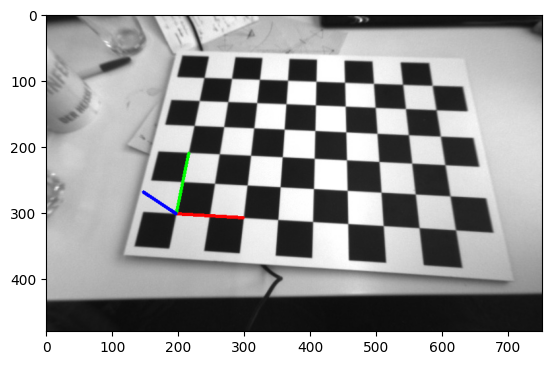

In [15]:
img1 = cv2.imread("datos\imagenes\img_001.jpg")
cv2.drawFrameAxes(img1,K,np.zeros(4),rvec,t,8,4)
plt.imshow(img1[:, :, ::-1])
cv2.imwrite("resultados\parte3.png",img1)

## *Parte 4A: Proyección de un Cubo*

*Calcular la matriz de proyección P = K[R |t] para cada uno de los fotogramas img_XXX.jpg de la carpeta datos\imagenes y utilizarla para proyectar un cubo de lado 8 cm sobre 4 casillas del tablero de ajedrez. Generar un video a 30 fotogramas por segundo con las imágenes resultantes. (Nota: en el caso que no sea posible detectar el tablero de ajedrez en alguno de los fotogramas, incluir el fotograma original sin el cubo)*



Este proceso recoge todos los apartados anteriores y va un paso más allá ya que ahora calculo la matriz de proyección gracias a el valor de K y la matriz compuesta de la rotación y la traslación y lo aplico para todas las imágenes donde se van a aplicar el cubo.

Primero se sacan los puntos de la realidad del cubo y en este caso sí se le dan valores en Z porque son los puntos que en la proyección van a ser la altura  del cubo en este caso de nuevo de 8cm.

Una vez elegidos los puntos llega el paso más importante que es aplicar la matriz de proyección a los puntos de la realidad. Básicamente sigue las siguiente fórmula x = P * X. Siendo P la matriz de proyección y X los puntos de la realidad. Lo único que hay que haces es realizar una multiplicación de matrices y después dividir entre el último valor para que se quede como coordenadas homogéneas con el último valor 1.

Finalmente se pinta de nuevo todos los valores nuevo proyectados con drawContours que guardo de nuevo todas las imágenes generadas en la carpeta cubo3D para dejar separado el proceso.

In [16]:
for i in range(1,736):
    img = cv2.imread("datos\imagenes\img_{0:03d}.jpg".format(i))
    [frames,found_corners] = cv2.findChessboardCorners(img,[6,9])
    if(frames != False):
        corners = np.squeeze(found_corners)
        p1 = corners[0,:]
        p2 = corners[5,:]
        p3 = corners[53,:]
        p4 = corners[48,:]
        puntos_p = np.array([p1,p2,p3,p4])
        H=homografia(puntos_p,puntos_PH1)
        p1,p2,p3,p4=new_points(H,P1c,P2c,P3c,P4c)

        R,t = camara(H)

        n = np.array([t]).T
        R_t = np.append(R,n,axis=1)

        P_proyeccion = K@R_t

        print(P_proyeccion)

        P1c = np.array([12,8,1])
        P2c = np.array([12,16,1])
        P3c = np.array([20,16,1])
        P4c = np.array([20,8,1])
        p1,p2,p3,p4=new_points(H,P1c,P2c,P3c,P4c)

        P1_3D =np.array([[12,8,8,1]])
        P2_3D =np.array([[12,16,8,1]])
        P3_3D =np.array([[20,16,8,1]])
        P4_3D =np.array([[20,8,8,1]])

        p1_resul = P_proyeccion@P1_3D.T
        p1_resul=np.int0(p1_resul.T/p1_resul[2])
        p2_resul = P_proyeccion@P2_3D.T
        p2_resul=np.int0(p2_resul.T/p2_resul[2])
        p3_resul = P_proyeccion@P3_3D.T
        p3_resul=np.int0(p3_resul.T/p3_resul[2])
        p4_resul = P_proyeccion@P4_3D.T
        p4_resul=np.int0(p4_resul.T/p4_resul[2])



        l = np.array([[p1,p2,p3,p4]])
        l2 = np.array([[p1_resul[0][0:2],p2_resul[0][0:2],p3_resul[0][0:2],p4_resul[0][0:2]]])


        cv2.imshow("frame",img)
        cv2.drawContours(img,l,-1,(0, 0, 255),thickness=2,lineType=cv2.LINE_AA)
        cv2.drawContours(img,l2,-1,(0, 0, 255),thickness=2,lineType=cv2.LINE_AA)
        cv2.line(img, p1,p1_resul[0][0:2], (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(img, p2,p2_resul[0][0:2], (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(img, p3,p3_resul[0][0:2], (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
        cv2.line(img, p4,p4_resul[0][0:2], (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

        cv2.destroyAllWindows()
        cv2.imwrite("resultados\cubo3D\parte"+str(i)+".png",img)

    else:
        cv2.imshow("frame",img)
        cv2.destroyAllWindows()
        cv2.imwrite("resultados\cubo3D\parte"+str(i)+".png",img)
    

[[ 4.01747896e+02  1.56106744e+02 -3.42299063e+02  6.43397478e+03]
 [ 9.27149689e+00 -3.00853564e+02 -3.85711907e+02  9.85970206e+03]
 [-4.97614596e-02  3.60574205e-01 -9.30930095e-01  3.26459945e+01]]
[[ 4.02458808e+02  1.55122011e+02 -3.41728786e+02  6.40137362e+03]
 [ 8.38062842e+00 -2.99967760e+02 -3.86392395e+02  9.94044261e+03]
 [-4.80462042e-02  3.62958503e-01 -9.30048970e-01  3.26343483e+01]]
[[ 4.02700733e+02  1.54388001e+02 -3.42139123e+02  6.39402057e+03]
 [ 7.30416214e+00 -3.00052546e+02 -3.86766500e+02  1.00006781e+04]
 [-4.75525461e-02  3.63650722e-01 -9.30524157e-01  3.26316028e+01]]
[[ 4.03875251e+02  1.52474703e+02 -3.41504676e+02  6.33862399e+03]
 [ 6.08767190e+00 -2.99901025e+02 -3.86487603e+02  1.00725437e+04]
 [-4.46428954e-02  3.63571285e-01 -9.29967853e-01  3.25955838e+01]]
[[ 4.04729634e+02  1.50530037e+02 -3.41996200e+02  6.27873714e+03]
 [ 4.42855170e+00 -3.00286418e+02 -3.87227440e+02  1.00989111e+04]
 [-4.25801484e-02  3.64749976e-01 -9.31363495e-01  3.25245

***Resultado Parte 4A:***

*resultados\parte4a.mp4 Video resultante.*

In [17]:
img1 = cv2.imread("datos\imagenes\img_001.jpg")
frame_width = img.shape[1]
frame_height = img.shape[0]

out_mp4 = cv2.VideoWriter("resultados\parte4a.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (frame_width, frame_height))

for i in range(1,736):
    frame = cv2.imread("resultados\cubo3D\parte"+str(i)+".png")
    out_mp4.write(frame)

out_mp4.release()